In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ray tracing
from OceanRays import CTDSoundSpeed,RayTrace,plotProfileRaypaths
# build tables
from OceanRays import interpXZT,buildTTLookupTable

import time
# run simple ray-path calculations through a theoretical (Munk) sound speed profile
# be careful of low angles when in the sofar channel for obvious reasons (waveguides)
initial_depth = 6000  # meters
max_range = 50e3    # meters (lateral distance)
angles = [-80, -65, -50, -35] # degrees
 
# From CTD Data
infile='CTD_examples/SKQ202409S_009.cnv'
profile, CMac = CTDSoundSpeed(infile)


Profile CTD_examples/SKQ202409S_009.cnv 
   taken at 53.0355, -163.5385
   Date Time 2024-06-28 15:37:10


In [2]:
# now loop over array of angles and depths
min_depth=0 # meters   (only need to build table for your specific depth and distance ranges.  Doing more now for vis)
max_depth=6000 # meters
dz=200 # meters (smaller steps are more accurate but more computationally expensive)

min_angle = -90 # degrees
max_angle = -40 # degrees
da = 0.5 # degrees (see dz)
max_range_m = 50000  # meters (max distance to calc ray path)

dt = 0.1  # seconds (see dz)

# Munk example
#lookupxzt = buildTTLookupTable([min_angle,max_angle,da],[min_depth,max_depth,dz],maxRange=max_range_m, dt=dt)

# using real data (much slower)
lookupxzt = buildTTLookupTable([min_angle,max_angle,da],[min_depth,max_depth,dz],maxRange=max_range_m, zProfile=profile['DEPTH'],cProfile=CMac, dt=dt)
print(f"Lookup table size: {len(lookupxzt)} entries.");
print("By default, lookup table will be saved as TTtable.pkl.  This doesn't need to be reran for same area")

Adjusting min_depth from 0 to 200
Building lookup table for travel time by (range, initial_depth)...
Calculating travel times for source depth: 200
Calculating travel times for source depth: 400
Calculating travel times for source depth: 600
Calculating travel times for source depth: 800
Calculating travel times for source depth: 1000
Calculating travel times for source depth: 1200
Calculating travel times for source depth: 1400
Calculating travel times for source depth: 1600
Calculating travel times for source depth: 1800
Calculating travel times for source depth: 2000
Calculating travel times for source depth: 2200
Calculating travel times for source depth: 2400
Calculating travel times for source depth: 2600
Calculating travel times for source depth: 2800
Calculating travel times for source depth: 3000
Calculating travel times for source depth: 3200
Calculating travel times for source depth: 3400
Calculating travel times for source depth: 3600
Calculating travel times for source dep

In [11]:
# Example usage:
# Once a table is created and loaded, determining the travel time to a specific point or distances is very fast
x = np.linspace(1000, 5500, 1001)
z = np.linspace(5000, 5000, 1001) 

start = time.time()
tcubic = interpXZT(x, z, lookupxzt, method='cubic')
end = time.time()

print("Predicted Travel Times:", tcubic)
print("Calculations for 1001 times:", end - start)


Predicted Travel Times: [3.40331177 3.40389974 3.40449012 ... 4.95724808 4.95948863 4.96172999]
Calculations for 1001 times: 0.05833601951599121


In [ ]:
# Load a saved version that has much higher sampling (only between 4500 and 6000 m depth)
lookupxzt2 = pickle.load(open("CTD_examples/SKQ_009_TTtable.pkl", "rb"))

print("Predicted Travel Times:", tcubic)
start = time.time()
tcubic = interpXZT(x, z, lookupxzt2, method='cubic')
end = time.time()

print("Predicted Travel Times:", tcubic)
print("Calculations for 1001 times:", end - start)


Predicted Travel Times: [3.40513472 3.40572214 3.40631678 ... 4.95899291 4.96120636 4.96342856]
Predicted Travel Times: [3.40513472 3.40572214 3.40631678 ... 4.95899291 4.96120636 4.96342856]
Calculations for 1001 times: 0.1625049114227295


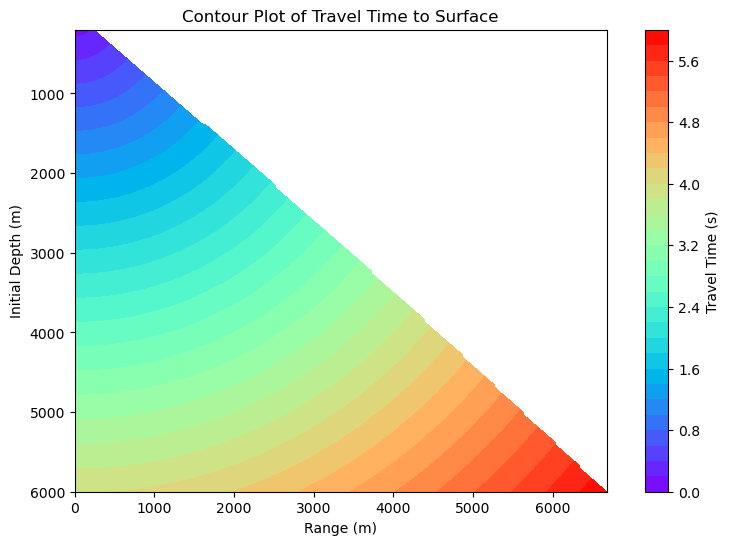

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for contour plot from lookupxzt
lookup_XZ = np.array(list(lookupxzt.keys()))  # shape (N, 2): columns are (range, depth)
lookup_times = np.array(list(lookupxzt.values()))  # shape (N,)

# Create grid for contour plot
range_grid = np.linspace(lookup_XZ[:,0].min(), lookup_XZ[:,0].max(), 200)
depth_grid = np.linspace(lookup_XZ[:,1].min(), lookup_XZ[:,1].max(), 200)
R, D = np.meshgrid(range_grid, depth_grid)
points = np.column_stack([R.ravel(), D.ravel()])

from scipy.interpolate import griddata
T = griddata(lookup_XZ, lookup_times, points, method='linear')
T = T.reshape(R.shape)

plt.figure(figsize=(10,6))
contour = plt.contourf(R, D, T, levels=30, cmap='rainbow')
plt.colorbar(contour, label='Travel Time (s)')
plt.xlabel('Range (m)')
plt.ylabel('Initial Depth (m)')
plt.title('Contour Plot of Travel Time to Surface')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()